In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train.zip
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/sample_submission.csv
/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv


In [2]:
 print(os.listdir("../input"))

['catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2']


In [3]:
# Import libraries and set desired options
import pickle
from pathlib2 import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'



In [4]:
# Read the training and test data sets, change paths if needed
train_df = pd.read_csv('../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv',
                      index_col='session_id')

# Convert time1, ..., time10 columns to datetime type
times = [f'time{i}' for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


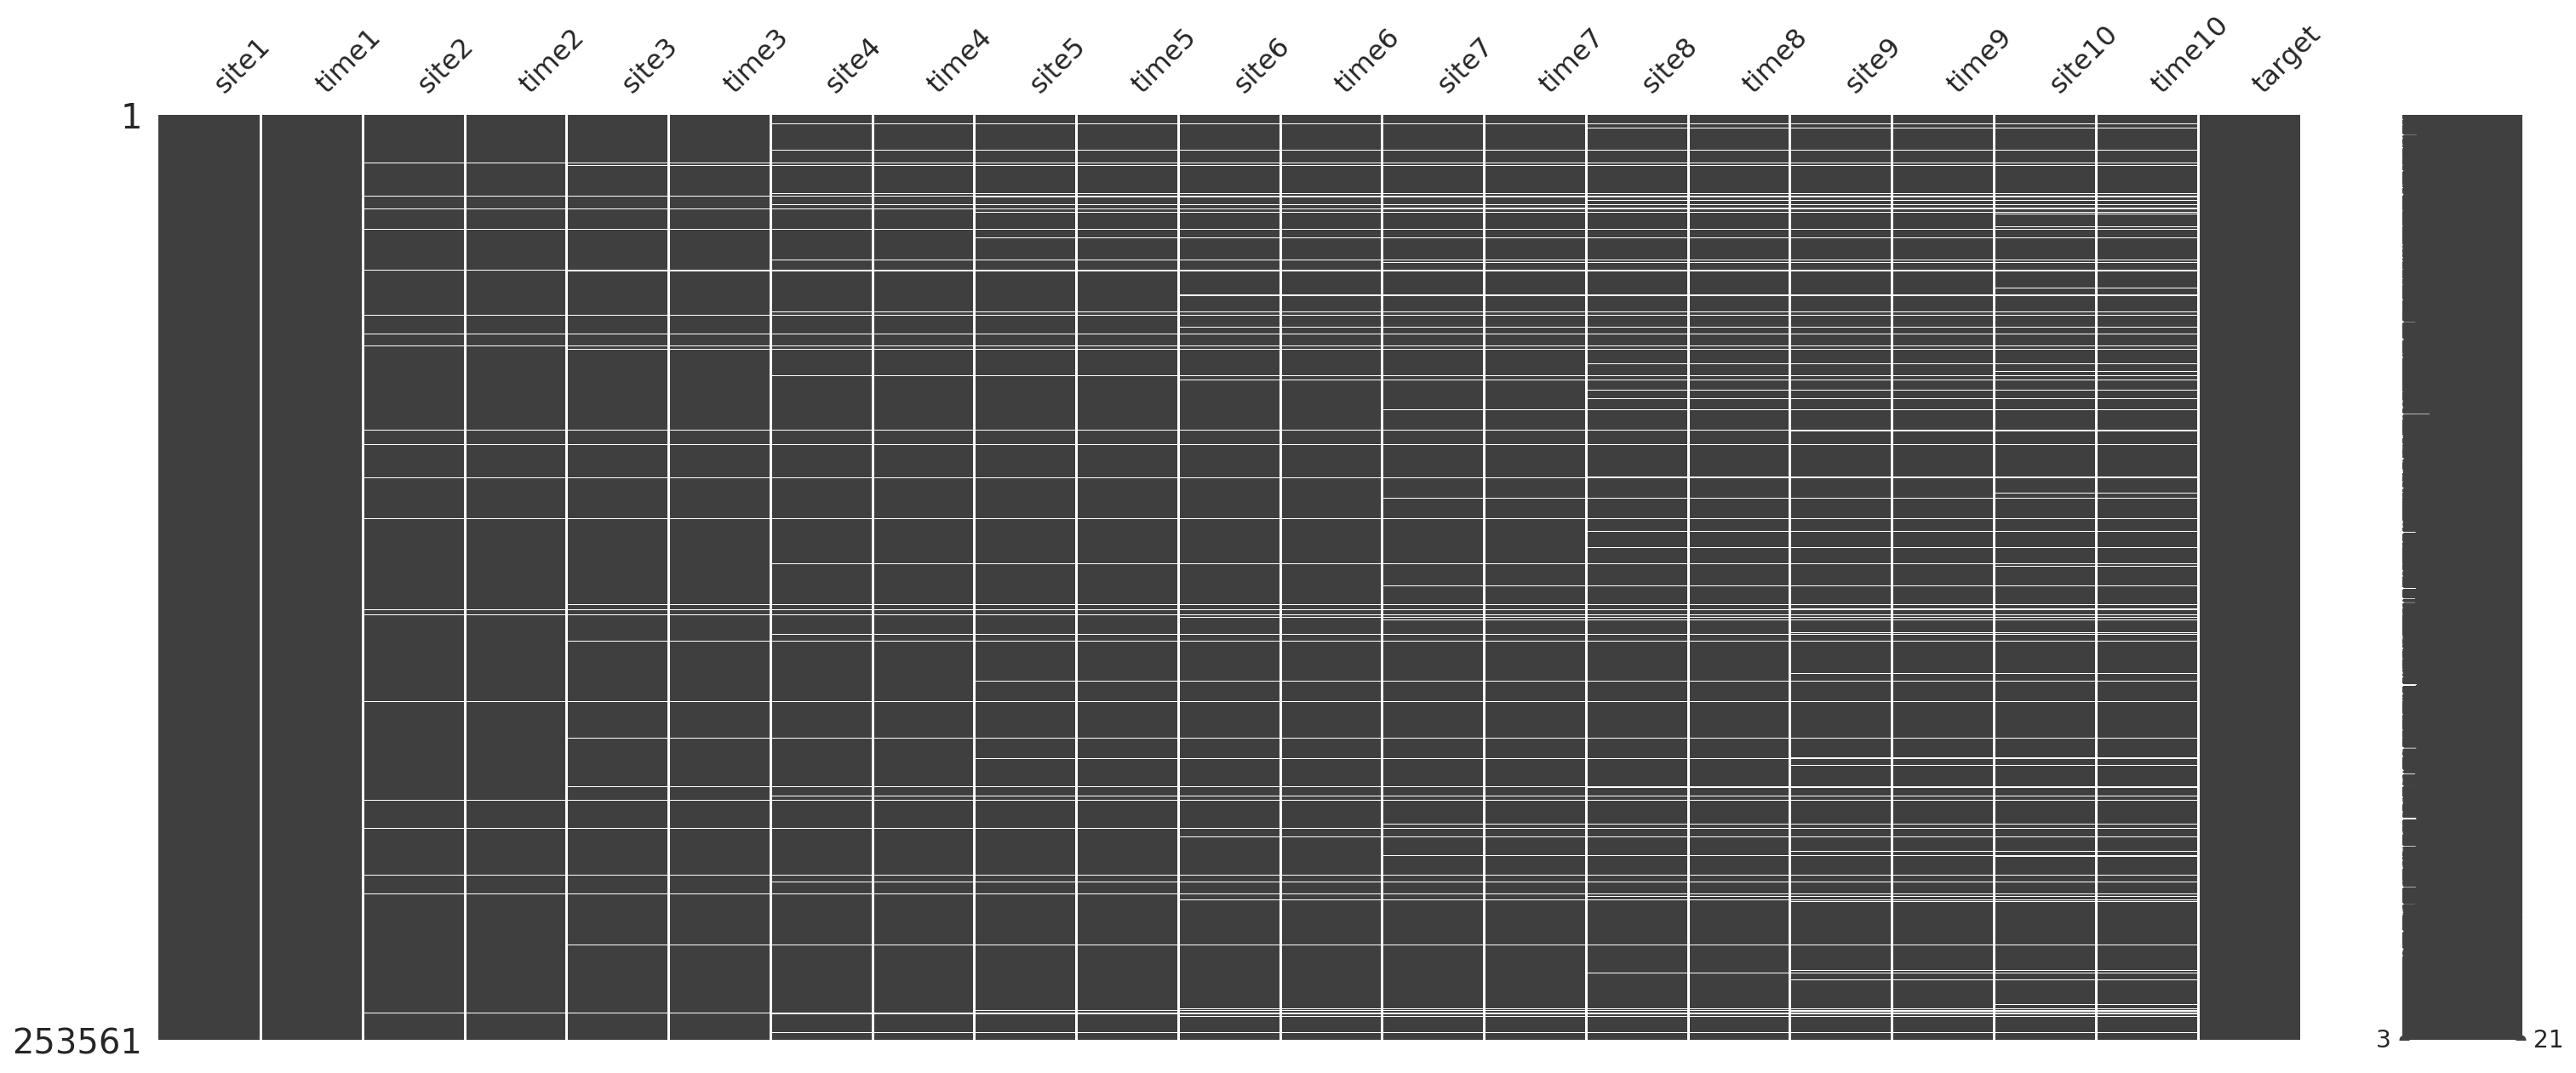

In [5]:
import missingno as mn
mn.matrix(train_df)

In [6]:
train_df.shape

(253561, 21)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


In [8]:
test_df.shape

(82797, 20)

In [9]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null datetime64[ns]
site3     80075 non-null float64
time3     80075 non-null datetime64[ns]
site4     79182 non-null float64
time4     79182 non-null datetime64[ns]
site5     78341 non-null float64
time5     78341 non-null datetime64[ns]
site6     77566 non-null float64
time6     77566 non-null datetime64[ns]
site7     76840 non-null float64
time7     76840 non-null datetime64[ns]
site8     76151 non-null float64
time8     76151 non-null datetime64[ns]
site9     75484 non-null float64
time9     75484 non-null datetime64[ns]
site10    74806 non-null float64
time10    74806 non-null datetime64[ns]
dtypes: datetime64[ns](10), float64(9), int64(1)
memory usage: 13.3 MB


In [10]:
train_df.isnull().sum()

site1         0
time1         0
site2      3463
time2      3463
site3      6642
time3      6642
site4      9240
time4      9240
site5     11732
time5     11732
site6     14066
time6     14066
site7     16264
time7     16264
site8     18337
time8     18337
site9     20477
time9     20477
site10    22509
time10    22509
target        0
dtype: int64

In [11]:
train_df.describe()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
count,253561.000000,250098.000000,246919.000000,244321.000000,241829.000000,239495.000000,237297.000000,235224.000000,233084.000000,231052.000000,253561.000000
mean,3243.550144,3272.400883,3303.987757,3325.109422,3343.406035,3352.312637,3395.546771,3430.157765,3438.400088,3460.388861,0.009059
std,7247.006212,7307.480404,7347.809918,7371.245606,7379.758550,7380.413775,7435.727671,7473.417900,7471.062652,7492.447548,0.094747
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,53.000000,53.000000,53.000000,52.000000,52.000000,52.000000,55.000000,55.000000,55.000000,55.000000,0.000000
50%,677.000000,677.000000,677.000000,677.000000,678.000000,679.000000,679.000000,704.000000,733.000000,733.000000,0.000000
75%,1980.000000,1980.000000,1986.500000,1995.000000,2054.000000,2077.000000,2197.000000,2287.000000,2366.000000,2403.000000,0.000000
max,41601.000000,41600.000000,41599.000000,41599.000000,41599.000000,41600.000000,41600.000000,41601.000000,41601.000000,41601.000000,1.000000


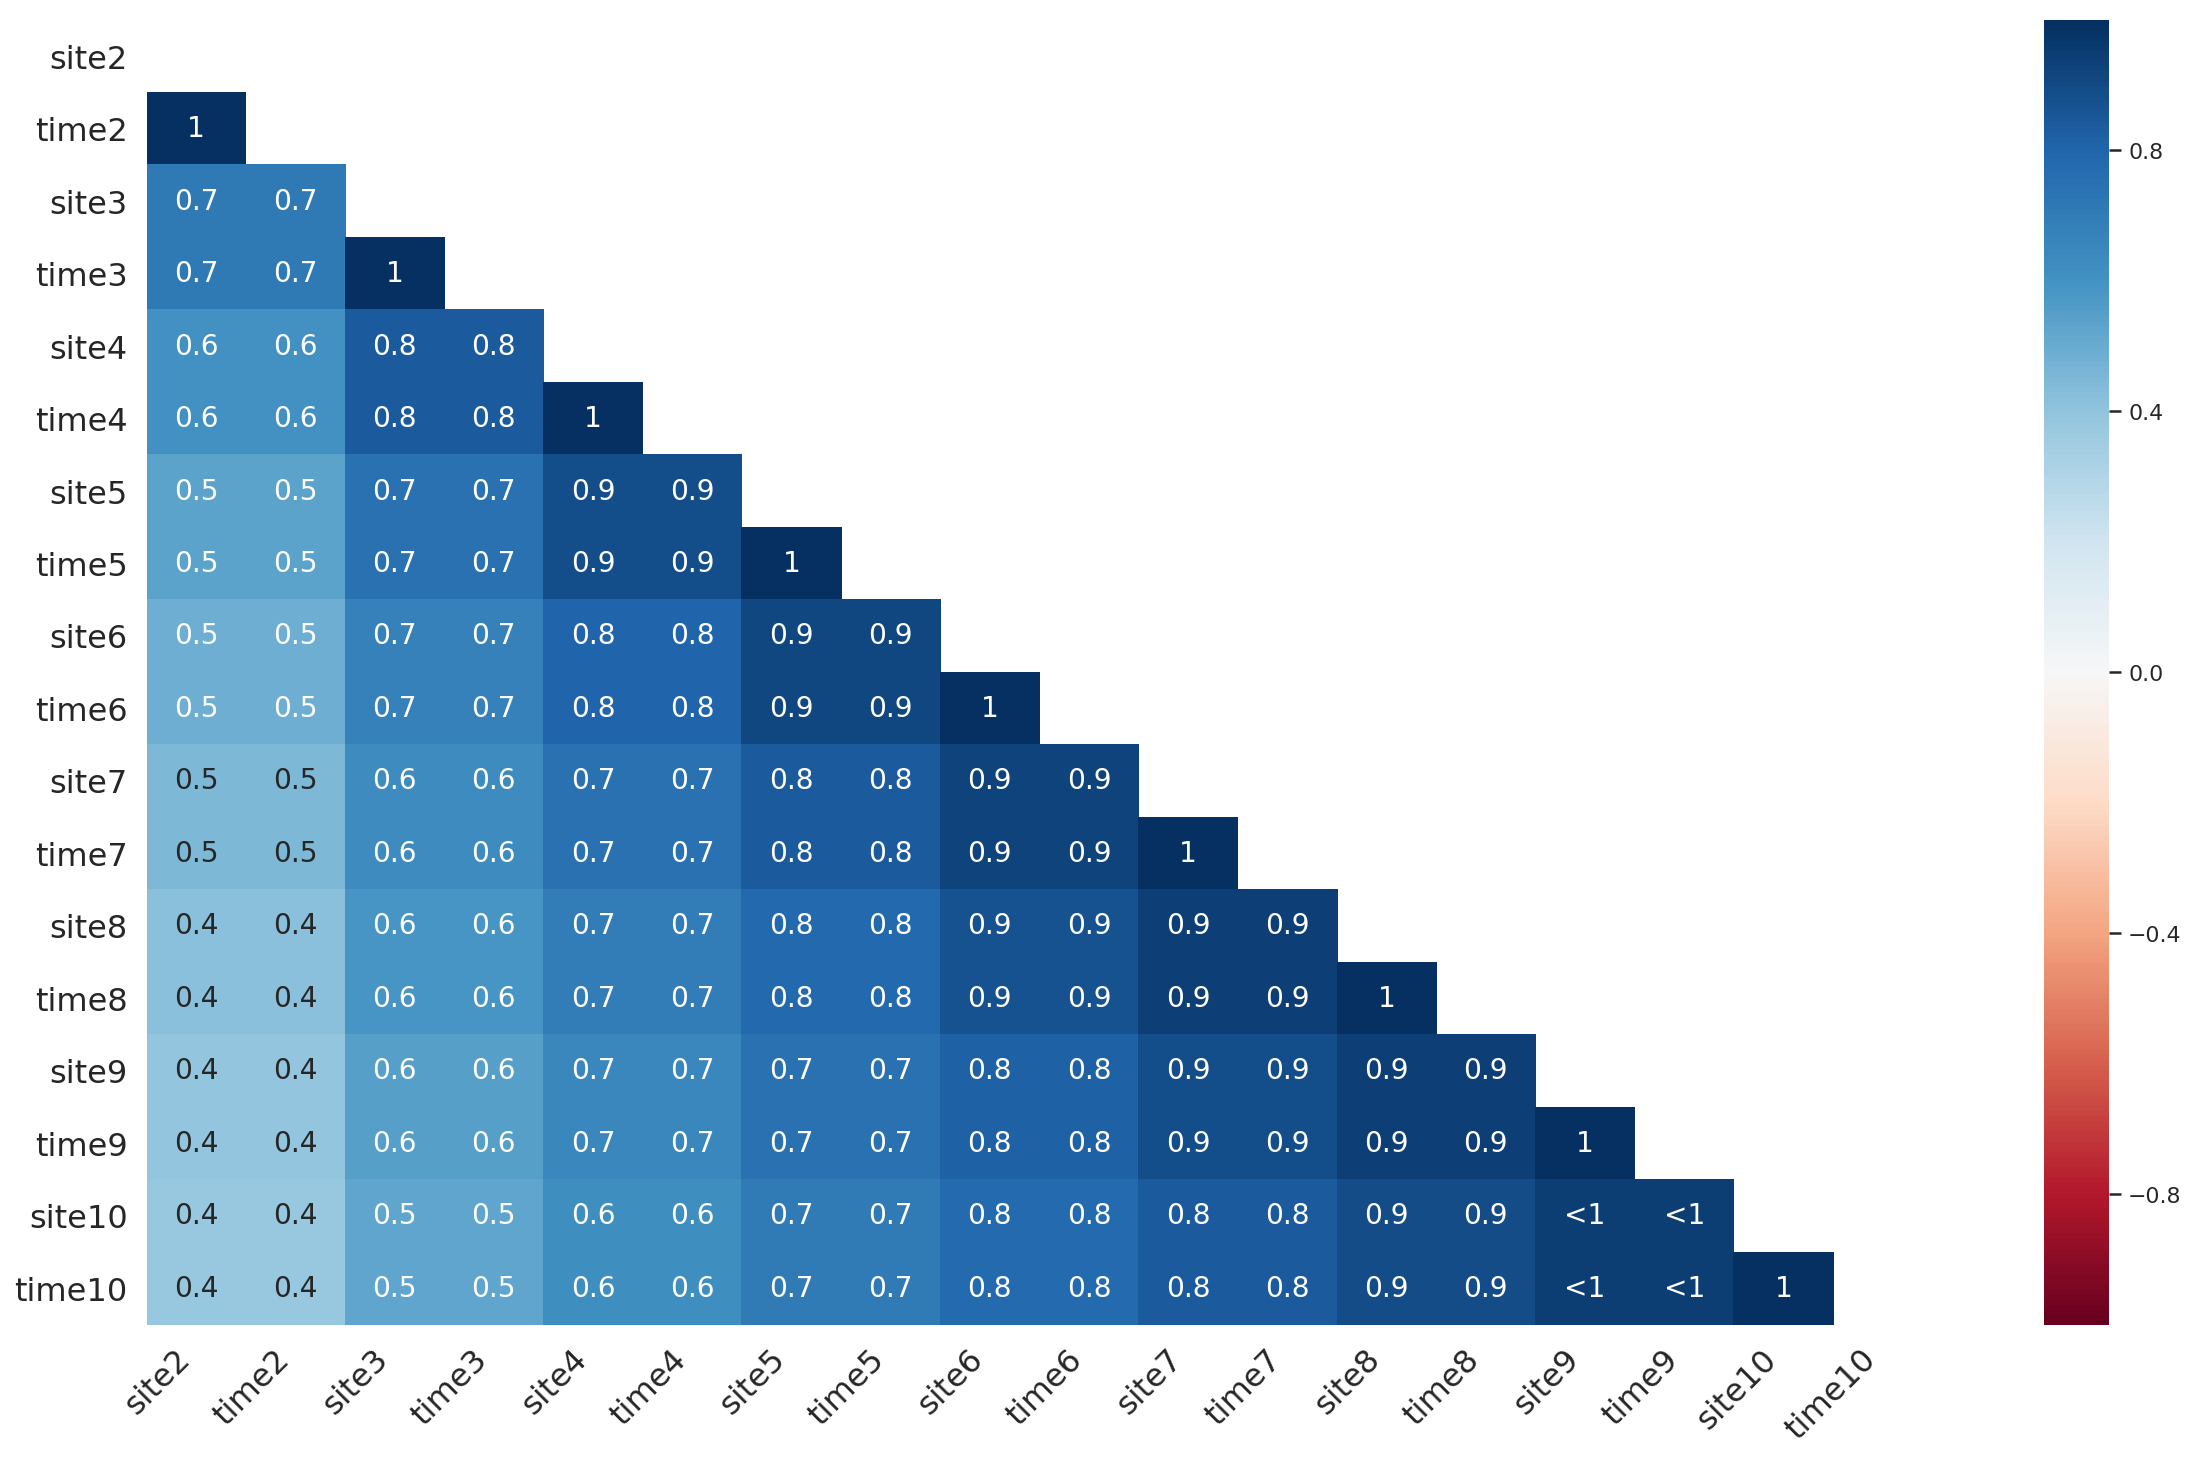

In [12]:
mn.heatmap(train_df)

In [13]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = [f'site{i}' for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open('../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print('Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [14]:
# What are the dimensions of the training and test sets (in exactly this order)?#

In [15]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [16]:
# Brief Exploratory Data Analysis

In [17]:
top_sites = pd.Series(train_df[sites].values.flatten()).value_counts()\
.sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


In [18]:
#What kind of websites does Alice visit the most?

In [19]:
top_alice_sites = pd.Series(train_df[train_df.target == 1][sites].values.flatten())\
                 .value_counts().sort_values(ascending=False).head(10)
print(top_alice_sites)


77     1382
80     1354
76     1307
29      897
21      857
81      609
879     522
22      522
75      451
82      447
dtype: int64


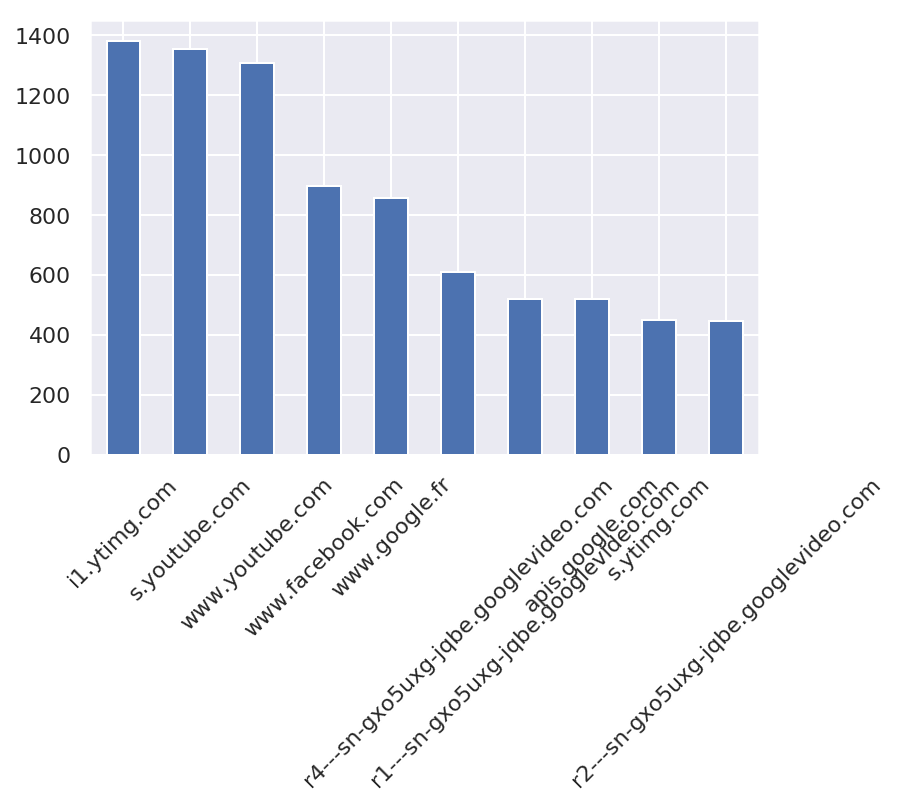

In [20]:
top_alice_sites.index = top_alice_sites.index.map(lambda x:sites_dict.loc[x]['site'])
top_alice_sites.plot(kind='bar',rot=45)


In [21]:
sites_dict.loc[top_alice_sites]

,site
1382,www.flytap.com
1354,c.speedtest.net
1307,www.youtube-nocookie.com
897,static.nrelate.com
857,s7.s-sfr.fr
609,img.over-blog.com
522,ams.nasa.gov
522,ams.nasa.gov
451,akamai.cedexis.com
447,www.cerimes.fr


In [22]:
#create a seperate dataframe where we will work 

In [23]:
#top_alice_sites[]

In [24]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


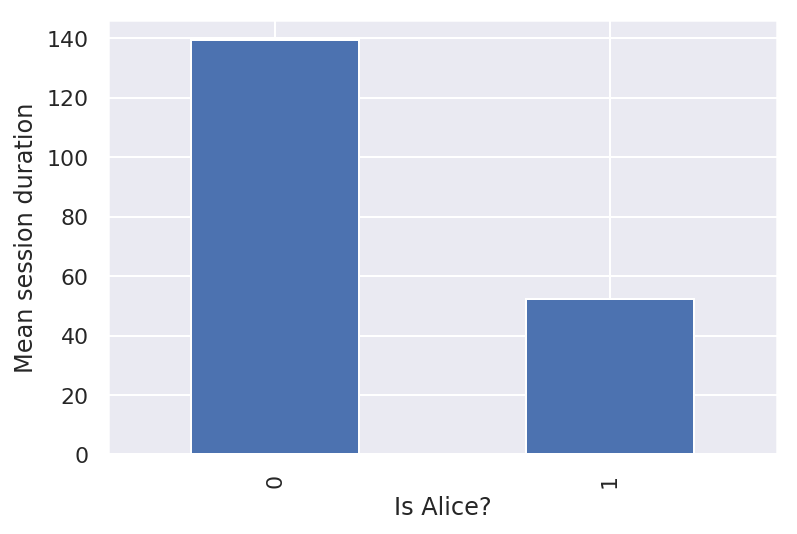

In [25]:
time_df.target = train_df.target
time_df.groupby('target').seconds.mean().plot(kind='bar')
plt.xlabel('Is Alice?')
plt.ylabel('Mean session duration')
plt.show()

In [26]:
alice_session_perc = time_df['target'].value_counts(normalize =True)[1]
print (f'{alice_session_perc:.2}% of all sessions belongs to alice')

0.0091% of all sessions belongs to alice


In [27]:
time_df.groupby('target').agg({'seconds':['min','max']})


seconds        
           min     max
target                
0          0.0  1800.0
1          0.0  1763.0

In [28]:
is_alice = time_df['target'] == 1
time_df['>=40s'] = time_df['seconds'].apply(lambda sec: 1 if sec >= 40 else 0)
ge40s_sessions_prec = time_df[is_alice]['>=40s'].value_counts(normalize=True)[1]
print(f'{ge40s_sessions_prec:.2}% of Allice sessions are >= 40 seconds.')

0.24% of Allice sessions are >= 40 seconds.


In [29]:
y_train = train_df['target']
full_df = pd.concat([train_df.drop('target',axis =1),test_df])
idx_split = train_df.shape[0]


In [30]:
#indx_split

NameError: name 'indx_split' is not defined

In [ ]:
full_df.shape, y_train.shape

In [ ]:
full_sites = full_df[sites]
full_sites.head()

In [ ]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)), dtype=np.int8)[:, 1:]

In [ ]:
full_sites_sparse.shape

In [ ]:
full_sites_sparse.dtype

In [ ]:
# How much memory does a sparse matrix occupy?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

In [ ]:
# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]
small_sites_dict = {
   1: 'vk.com',
   2: 'habrahabr.ru',
   3: 'yandex.ru',
   4: 'ods.ai'
}
sites_cols = [small_sites_dict[i+1] for i in range(len(small_sites_dict))]
# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]
# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
sparsed = csr_matrix((data, indices, indptr))[:, 1:]
pd.DataFrame(sparsed.todense(), columns=sites_cols)

In [ ]:
non_zero = sparsed.count_nonzero()
all_elements = sparsed.shape[0]*sparsed.shape[1]
zero_elements = all_elements-non_zero
sparsness = zero_elements/all_elements
print(f'Sparsness is {sparsness*100:.2f}%')

In [ ]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [ ]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

In [ ]:
full_df['time1'].map(lambda x: x.year).unique()

In [ ]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [ ]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')


In [ ]:
# Your code is here
train_df['start_month'] = full_new_feat[:idx_split]['start_month']
alice_sessions = train_df.groupby(by='start_month').agg({'target': 'sum'})
alice_sessions.plot(kind='bar', rot=60, legend=False,
                    title='Number of Alice sessions versus the start_month');


In [ ]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
# Add the new standardized feature to the sparse matrix
scaled_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], scaled_start_month[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
# Your code is here
full_new_feat['nunique_site']=full_df[sites].nunique(axis=1)

In [ ]:
X_train = csr_matrix(
    hstack(
        (full_sites_sparse[:idx_split, :],
         scaled_start_month[:idx_split, :],
         full_new_feat[['nunique_site']].values[:idx_split, :])
    )
)
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
scaled_nunique_site = StandardScaler().fit_transform(full_new_feat[['nunique_site']])
X_train = csr_matrix(
    hstack(
        (full_sites_sparse[:idx_split, :],
         scaled_start_month[:idx_split, :],
         scaled_nunique_site[:idx_split, :])
    )
)
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
# Your code is here
full_new_feat['start_hour'] = full_df['time1'].map(lambda x: x.hour).astype('float64')



In [ ]:
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype('int8')

In [ ]:
X_train = csr_matrix(
    hstack(
        (full_sites_sparse[:idx_split, :],
         scaled_start_month[:idx_split,:],
         full_new_feat[['morning']].values[:idx_split])
    )
)
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
X_train = csr_matrix(
    hstack(
        (full_sites_sparse[:idx_split, :],
         scaled_start_month[:idx_split,:],
         full_new_feat[['start_hour']].values[:idx_split])
    )
)
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
scaled_start_hour = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train = csr_matrix(
    hstack(
        (full_sites_sparse[:idx_split, :],
         scaled_start_month[:idx_split,:],
         scaled_start_hour[:idx_split])
    )
)
print(get_auc_lr_valid(X_train, y_train))

In [ ]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

In [ ]:
# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in Cs:
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

In [ ]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

In [ ]:
# Your code is here
best_C = Cs[np.argmax(scores)]
print(f'C={best_C:.2f} corresponds to the highest model quality')

In [ ]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=best_C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')

In [ ]:
from IPython.display import FileLinks
FileLinks('.')